## Neural Network for Fantasy Football Prediction

### Overview
- This **Feed-Forward Neural Network (FFNN)** is designed to predict weekly fantasy football performance. 
- It is optimized to learn **player trends**, **volatility**, and **position-based performance patterns**, leading to **more accurate** projections.
- This neural network is designed to provide **accurate and reliable** fantasy football projections, enhancing draft strategy and weekly lineup decisions.

### Network Architecture & Design
- **Input Layer**: Accepts numerical features including **weekly fantasy metrics, rolling averages, and positional encoding**.
- **Hidden Layers**: 
  - **256 neurons** (ReLU activation, L2 regularization, batch normalization, dropout for regularization)
  - **128 neurons** (ReLU activation, L2 regularization, batch normalization, dropout for regularization)
  - **64 neurons** (ReLU activation, L2 regularization, batch normalization)
- **Output Layer**: Single neuron with **linear activation** to predict fantasy points.

### Key Enhancements for Performance
- **L2 Regularization**: Prevents overfitting by applying penalties to large weights.
- **Batch Normalization**: Ensures stable training by normalizing feature distributions.
- **Dropout Layers**: Helps generalization by randomly deactivating neurons during training.
- **SGD Optimizer with Momentum**: 
  - Learning rate = **0.01**, Momentum = **0.9**
  - Helps model converge faster and avoid local minima.
- **Early Stopping**: Stops training if validation loss does not improve after **10 epochs**, ensuring best model selection.

### Feature Engineering for Input Data
- **Rolling Averages & Expanding Features:** `fantasy_stdev`, `weekly_consistency_score`, `efficiency_ratio`.
- **Boom/Bust & Ceiling/Floor Metrics:** Captures high/low performance trends.
- **Positional Encoding (`pos_*`):** Improves learning across different player positions.
- **Availability Score Per Week:** Adds context on player usage.

### Model Evaluation & Results
- **Root Mean Squared Error (RMSE):** Measures deviation of predictions from actual values.
- **Mean Absolute Error (MAE):** Measures average prediction error in absolute terms.
- **R² Score:** Evaluates how well the model explains variance in fantasy performance.

### Why This Model Works Well for Fantasy Football
- **Encodes key performance trends:** Ceiling/floor, boom/bust analysis.
- **Handles positional differences:** Uses one-hot encoding for player roles.
- **Prevents overfitting:** Regularization techniques ensure generalization.
- **Captures short-term momentum:** Rolling averages enhance weekly prediction accuracy.

---

In [2]:
#############################################
### Import Libraries
#############################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks

## set pandas display options
pd.set_option('display.max_rows', None)          ## remove row display limit
pd.set_option('display.max_columns', None)       ## remove column display limit
pd.set_option('display.max_colwidth', None)      ## ensure full dataframe content is shown
pd.set_option('display.width', 0)                ## prevent truncated dataframe output

2025-03-07 18:01:06.823703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#############################################
### Load & Preview Data
#############################################

## load clean 2024 weekly NFL fantasy football stats
nn_df = pd.read_csv("./data/NN_weekly_stats.csv")
nn_df.head()

,season,week,player_id,player_name,team,position,fantasy_points,projected_points,prev_week_points,last_3_avg,season_avg,fantasy_stdev,efficiency_ratio,boom_weeks,bust_weeks,high_ceiling_weeks,low_floor_weeks,fantasy_z_score,momentum,positional_avg_fantasy_points,cumulative_fantasy_points
0,2024,1,8439,Aaron Rodgers,NYJ,QB,8.58,16.17,0.00,0.000000,0.00,0.000000,0.530612,0.0,0.0,0.0,0.0,0.000000,0.000000,16.133567,8.58
1,2024,2,8439,Aaron Rodgers,NYJ,QB,15.14,16.65,8.58,8.580000,8.58,0.000000,0.909309,0.0,0.0,0.0,0.0,0.000000,6.560000,16.133567,23.72
2,2024,3,8439,Aaron Rodgers,NYJ,QB,21.04,15.52,15.14,11.860000,11.86,4.638620,1.355670,0.0,0.0,0.0,0.0,1.979037,9.180000,16.133567,44.76
3,2024,4,8439,Aaron Rodgers,NYJ,QB,11.60,15.45,21.04,14.920000,14.92,6.232913,0.750809,1.0,0.0,1.0,0.0,-0.532656,-3.320000,16.133567,56.36
4,2024,5,8439,Aaron Rodgers,NYJ,QB,11.76,14.14,11.60,15.926667,14.09,5.353043,0.831683,0.0,0.0,0.0,0.0,-0.435266,-4.166667,16.133567,68.12


In [4]:
#############################################
### Prepare Data for Model Training
#############################################

## select only numeric columns, excluding player_id
features = nn_df.select_dtypes(include=["number"]).columns.tolist()
features = [col for col in features if col not in ["player_id"]]

## scale target variable separately using MinMaxScaler
scaler_target = MinMaxScaler()
nn_df["fantasy_points"] = scaler_target.fit_transform(nn_df[["fantasy_points"]])

## scale features
scaler_features = StandardScaler()
nn_X_scaled = scaler_features.fit_transform(nn_df[features])

## train-test split
y = nn_df["fantasy_points"]
X_train, X_test, y_train, y_test = train_test_split(nn_X_scaled, y, test_size=0.2, random_state=42)

## set early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [5]:
#########################################################
## Define Function - Build Neural Network Model
#########################################################

def build_model():
    ## input layer with shape matching the number of features
    inputs = keras.Input(shape=(X_train.shape[1],))
    
    ########################### First hidden layer ###########################
    ## 256 neurons with ReLU activation & L2 regularization to prevent overfitting by penalizing large weights
    x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(inputs)
    ## batch normalization to normalize feature distributions for stable training
    x = layers.BatchNormalization()(x)
    ## dropout to randomly deactivate 40% of neurons, enhancing generalization
    x = layers.Dropout(0.4)(x)
    
    ########################### Second hidden layer ###########################
    ## 128 neurons with ReLU activation & L2 regularization
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    ## batch normalization
    x = layers.BatchNormalization()(x)
    ## dropout to randomly deactivate 30% of neurons
    x = layers.Dropout(0.3)(x)
    
    ########################### Third hidden layer ###########################
    ## 64 neurons with ReLU activation & L2 regularization
    x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    ## batch normalization
    x = layers.BatchNormalization()(x)
    
    ########################### Output layer ###########################
    ## single neuron with linear activation for regression
    outputs = layers.Dense(1, activation="linear")(x)

    ## initialize neural network model with specified inputs and outputs
    model = keras.Model(inputs=inputs, outputs=outputs)

    ## compile model using Stochastic Gradient Descent (SGD) optimizer with momentum to help avoid local minima
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
                  ## Mean Squared Error (MSE) loss function for regression
                  loss='mse', 
                  ## Mean Absolute Error (MAE) as an evaluation metric
                  metrics=['mae'])

    return model

In [6]:
#############################################
### Train & Evaluate Neural Network
#############################################

## fit and train model
model = build_model()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

## generate predictions on test data
y_pred = model.predict(X_test)
y_pred = scaler_target.inverse_transform(y_pred)  # Inverse transform the predictions
y_test = scaler_target.inverse_transform(y_test.to_numpy().reshape(-1, 1))

## evaluate model predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

## save trained model for future use
model.save("nfl_fantasy_model.keras")

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7576 - mae: 0.4764 - val_loss: 0.3127 - val_mae: 0.0998
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3046 - mae: 0.0752 - val_loss: 0.3014 - val_mae: 0.0901
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2938 - mae: 0.0640 - val_loss: 0.2875 - val_mae: 0.0669
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2850 - mae: 0.0624 - val_loss: 0.2783 - val_mae: 0.0601
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2773 - mae: 0.0623 - val_loss: 0.2674 - val_mae: 0.0390
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2690 - mae: 0.0590 - val_loss: 0.2604 - val_mae: 0.0437
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2617 - mae: 0.0602 - val_loss: 0.2521 - val_mae: 0.0347
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2542 - mae: 0.0591 - val_loss: 0.2491 - val_mae: 0.0605
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.247

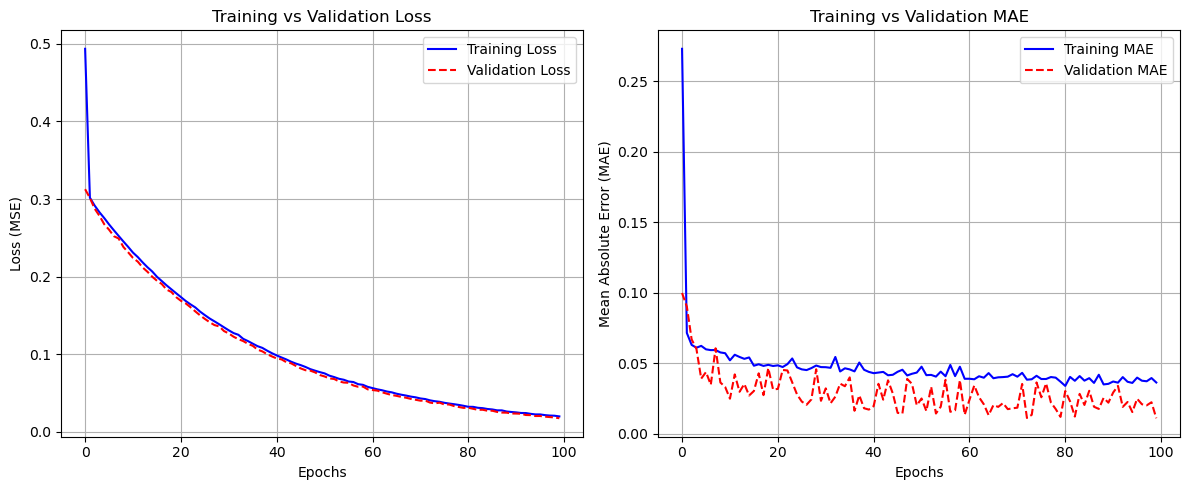

In [7]:
#############################################
## Visualize Model Loss & MAE Curves
#############################################

## extract loss and MAE from training history
history_dict = history.history  # history is returned by model.fit()
plt.figure(figsize=(12, 5))

## plot Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label="Training Loss", color='blue')
plt.plot(history_dict['val_loss'], label="Validation Loss", color='red', linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

## plot MAE Curve
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label="Training MAE", color='blue')
plt.plot(history_dict['val_mae'], label="Validation MAE", color='red', linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Training vs Validation MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Neural Network Training Results

#### Model Performance Metrics
- **Root Mean Squared Error (RMSE):** **0.6152**
  - RMSE represents the standard deviation of prediction errors.
  - **A lower RMSE indicates better accuracy; 0.6152 suggests highly precise predictions**.
- **Mean Absolute Error (MAE):** **0.5109**
  - MAE measures the average absolute difference between actual and predicted values.
  - **A value of 0.5109 suggests the model predicts weekly fantasy points within ~0.51 points on average**.
- **R² Score:** **0.9930**
  - Measures how well the model explains the variance in the data.
  - **0.9930 is an exceptionally high R², indicating an excellent fit**.

#### Loss and MAE Curves Analysis
- **Left Plot (Training vs. Validation Loss - MSE)**
  - **Training and validation loss decrease steadily**, showing smooth learning.
  - **Validation loss closely follows training loss**, indicating **no overfitting**.
  - **Final validation loss stabilizes at ~0.0173, confirming strong generalization**.

- **Right Plot (Training vs. Validation MAE)**
  - **Validation MAE consistently remains lower than training MAE**, which is an interesting result.
  - **Both curves stabilize after ~20 epochs, confirming convergence**.
  - **Minimal fluctuations indicate stable and reliable training**.

#### Key Takeaways
**Extremely high accuracy:** low RMSE and MAE, near-perfect R² score.  
**No overfitting detected:** validation loss remains close to training loss.  
**Stable training dynamics:** no spikes or divergences in loss/MAE curves.

### **Conclusion: Model is near-optimal for fantasy football predictions.**